In [8]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from matplotlib.patches import Rectangle
from functools import lru_cache
from z3 import *

In [9]:
#https://www.gmpuzzles.com/blog/pentominous-rules-info/

fixed = [((0,0),'T'),
         ((0,7),'N'),
         ((0,9),'V'),
         ((2,4),'W'),
         ((4,5),'L'),
         ((4,9),'N'),
         ((5,0),'V'),
         ((5,4),'Y'),
         ((7,5),'W'),
         ((9,0),'T'),
         ((9,2),'T'),
         ((9,9),'L'),
        ]

fixed = [((j,i),p) for ((i,j),p) in fixed]
    
labels = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']    
[(i,j,labels.index(p)) for ((i,j),p) in fixed]

[(0, 0, 6),
 (7, 0, 4),
 (9, 0, 8),
 (4, 2, 9),
 (5, 4, 3),
 (9, 4, 4),
 (0, 5, 8),
 (4, 5, 11),
 (5, 7, 9),
 (0, 9, 6),
 (2, 9, 6),
 (9, 9, 3)]

In [10]:
def reset(positions):
    min_x, min_y = min(positions, key=lambda x:x[::-1])
    return tuple(sorted((x-min_x, y-min_y) for x, y in positions))

def variation(positions):
    return list({reset(var) for var in (
        positions,
        [( x,  y) for x, y in positions], # original
        [(-y,  x) for x, y in positions], # Anti-clockwise 90
        [(-x, -y) for x, y in positions], # 180
        [( y, -x) for x, y in positions], # Clockwise 90

        [(-x,  y) for x, y in positions], # Mirror vertical
        [(-y, -x) for x, y in positions], # Mirror diagonal
        [( x, -y) for x, y in positions], # Mirror horizontal
        [( y,  x) for x, y in positions], # Mirror diagonal
    )})

def orientation(x,y,shape,A,B):
    for (alpha,beta) in shape:
        links = []
        for (i,j) in shape:
            if (i,j) !=(alpha,beta):
                if  (x+i-alpha >= 0) & (x+i-alpha <A) & (y+j-beta >=0) &  (y+j-beta <B):
                     links.append((x+i-alpha,y+j-beta))
    
            if len(links) == len(shape)-1:
                yield links
            
@lru_cache(maxsize=None)
def get_shapes(n):
    shapes = [
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 0)), "F"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (0, 4)), "I"),
    (((0, 0), (0, 1), (0, 2), (0, 3), (1, 3)), "L"),
    (((0, 2), (0, 3), (1, 0), (1, 1), (1, 2)), "N"),
    (((0, 0), (0, 1), (0, 2), (1, 0), (1, 1)), "P"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 0)), "T"),
    (((0, 0), (0, 1), (1, 1), (2, 0), (2, 1)), "U"),
    (((0, 0), (0, 1), (0, 2), (1, 2), (2, 2)), "V"),
    (((0, 0), (0, 1), (1, 1), (1, 2), (2, 2)), "W"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (2, 1)), "X"),
    (((0, 1), (1, 0), (1, 1), (1, 2), (1, 3)), "Y"),
    (((0, 0), (1, 0), (1, 1), (1, 2), (2, 2)), "Z")
    ]

    return {shape: variation(shape) for shape, name in [shapes[n-1]]}
    
    
def forced(x,y,A,B,n):
    shape_variations = get_shapes(n)

    for key,vals in shape_variations.items():
        poss = []
        for val in vals:
            poss += [*orientation(x,y,val,A,B)]
    
        return (poss)
    
def place(x,y,n,X,N):
    return Or([
        And([X[i,j]==n for i,j in force]+[X[i,j] !=n for i,j in exclude_neighbours(x,y,force,N)]) 
        for force in forced(x,y,N[0],N[1],n)
            ])

def neighbours(i,j,N):
    l=[]
    if i-1 >= 0:
        l.append((i-1,j))
    if i+1 < N[0]:
        l.append((i+1,j))
    if j-1 >= 0:
        l.append((i,j-1))
    if j+1 < N[1]:
        l.append((i,j+1))
    return l

def exclude_neighbours(a,b,force,N):
    x = force+[(a,b)]
    exclude = []
    for i,j in x:
        exclude += [n for n in neighbours(i,j,N)]
    return list(set(exclude)-set(x))

In [11]:
def fill(N,blank=[],fixed = []):
    start = time.time()
    
    s = Tactic('default').solver()
    
    
    X = np.array([[Int("X_%s%s" % (i+1,j+1)) for j in range(N[1]) ] for i in range(N[0]) ],dtype=object)

    # force blank/non-blank
    labels = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']    
       
    s += [X[i,j] == labels.index(p) for ((i,j),p) in fixed]

    # the big one. Set the placements round a given cell for each pentomino
    s += [Implies(X[i,j] == n,place(i,j,n,X,N)) for n in range(1,13) for j in range(N[1]) for i in range(N[0])]

    #limit the cells to 0 (blank) or 1-12 (pentomino)
    s += [Or([X[i,j]==n for n in range(1,13)]) for j in range(N[1]) for i in range(N[0]) ]

    #either 5 or 0 of each number
    s += [Sum([If(X[i,j]==n,1,0) for j in range(N[1]) for i in range(N[0])]) % 5 == 0  for n in range(1,13)]
       
    print("SETUP DONE .. in {:0.4f} seconds".format(time.time()-start))
    if s.check() == sat:
        m = s.model()
        x = np.array([[m.evaluate(X[i,j]).as_long() for j in range(N[1])] for i in range(N[0])])
        fig,ax = plt.subplots(1,1,figsize=(N[1]/2,N[0]/2)) 
        y = np.array(x).astype('int').astype('str')
        shapes = [' ','F', 'I', 'L', 'N', 'P', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        mapping = np.vectorize(lambda x:shapes[x])
        shading = mapping(x)
        sns.heatmap(x,annot=shading,cbar=False,cmap="gist_ncar_r",fmt="",linewidths=1,linecolor="grey",annot_kws={"size":12},vmin=0,vmax=12,alpha=0.5)
        ax.axis("off")
        for ((i,j),p) in fixed:
             ax.add_patch(Rectangle((j,i), 1, 1, fill=False, edgecolor='r', lw=3))
        plt.show()
        #print(s.statistics())
    print('Solution took {:0.4f} seconds'.format(time.time()-start))

SETUP DONE .. in 2.0605 seconds


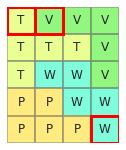

Solution took 2.1463 seconds


In [12]:
N= [5,4]
fill(N,fixed=[((0,0),'T'),((0,1),'V'),((4,3),'W')])


SETUP DONE .. in 25.3602 seconds


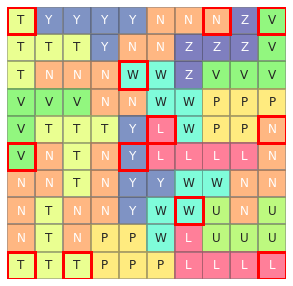

Solution took 27.4057 seconds


In [13]:
fixed = [((0,0),'T'),
         ((0,7),'N'),
         ((0,9),'V'),
         ((2,4),'W'),
         ((4,5),'L'),
         ((4,9),'N'),
         ((5,0),'V'),
         ((5,4),'Y'),
         ((7,6),'W'),
         ((9,0),'T'),
         ((9,2),'T'),
         ((9,9),'L'),
        ]

N= [10,10]
fill(N,fixed=fixed)

SETUP DONE .. in 25.7601 seconds


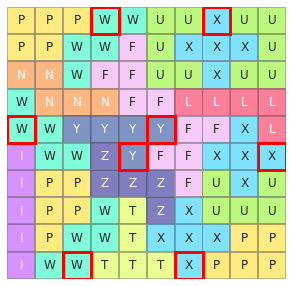

Solution took 27.2611 seconds


In [14]:
#https://www.gmpuzzles.com/blog/2021/04/pentominous-by-jinhoo-ahn-4/

fixed = [((0,3),'W'),
         ((0,7),'X'),
         ((4,0),'W'),
         ((4,5),'Y'),
         ((5,4),'Y'),
         ((5,9),'X'),
         ((9,2),'W'),
         ((9,6),'X')
         
        ]

N= [10,10]
fill(N,fixed=fixed)